# CrateRover Requirements

This document records the requirements for the CrateRover, a robot designed to pick-up, carry and deposit a single crate
containing goods. The rover consists of a base, which carries the cargo, and a set of lifting arms, which can lift
the cargo onto and off the base.

The rover base containings the carrier platform onto which the cargo is placed, the drive system and the electronics
package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from robot_functions import *

## Requirements

The required performance values for the rover are defined as follows

### Cargo

The CrateRover should be able to carry a single [crate](https://www.mitre10.co.nz/shop/number-8-collapsible-crate-48-litre-blue/p/323388) with the
following dimensions and weight. 

In [2]:
# Cargo
crate_mass_in_kg = 25.0

crate_length_in_meters = 0.520
crate_width_in_meters = 0.350
crate_height_in_meters = 0.268

crate_data = [["Maximum weight (kg)", crate_mass_in_kg],
              ["Length (m)", crate_length_in_meters],
              ["Width (m)", crate_width_in_meters],
              ["Height (m)", crate_height_in_meters]]
pd.DataFrame(crate_data, columns=["Crate information", "Value"])


,Crate information,Value
0,Maximum weight (kg),25.000
1,Length (m),0.520
2,Width (m),0.350
3,Height (m),0.268


### Rover

In [3]:
# Rover
max_velocity_flat = 4.0
max_velocity_hill = 2.0

max_hill_angle_empty = 45.0
max_hill_angle_max_load = 30.0

battery_life_in_hours = 5.0

# Dimensions
wheel_radius = 0.075

rover_mass_in_kg = 20.0

rover_length = 1.0
rover_width = crate_width_in_meters + 0.30
rover_height = wheel_radius * 2 + crate_height_in_meters + 0.10

number_of_wheels = 6

# random

coefficient_of_friction_max = 1.00
coefficient_of_friction = 0.25
coefficient_of_aerodynamic_drag = 1.00

# Output

rover_data = [
    ["Maximum speed on the flat (m/s)", max_velocity_flat],
    ["Maximum speed on a hill (m/s)", max_velocity_hill],
    ["Maximum hill angle without load (degrees)", max_hill_angle_empty],
    ["Maximum hill angle with load (degrees)", max_hill_angle_max_load],
    ["Battery life (hours)", battery_life_in_hours]
]
pd.DataFrame(rover_data, columns=["Rover information", "Value"])


,Rover information,Value
0,Maximum speed on the flat (m/s),4.0
1,Maximum speed on a hill (m/s),2.0
2,Maximum hill angle without load (degrees),45.0
3,Maximum hill angle with load (degrees),30.0
4,Battery life (hours),5.0


## Rover base sizing

Sizing the rover base is done by calculating the loads on the different components of the rover base

### Drive motors


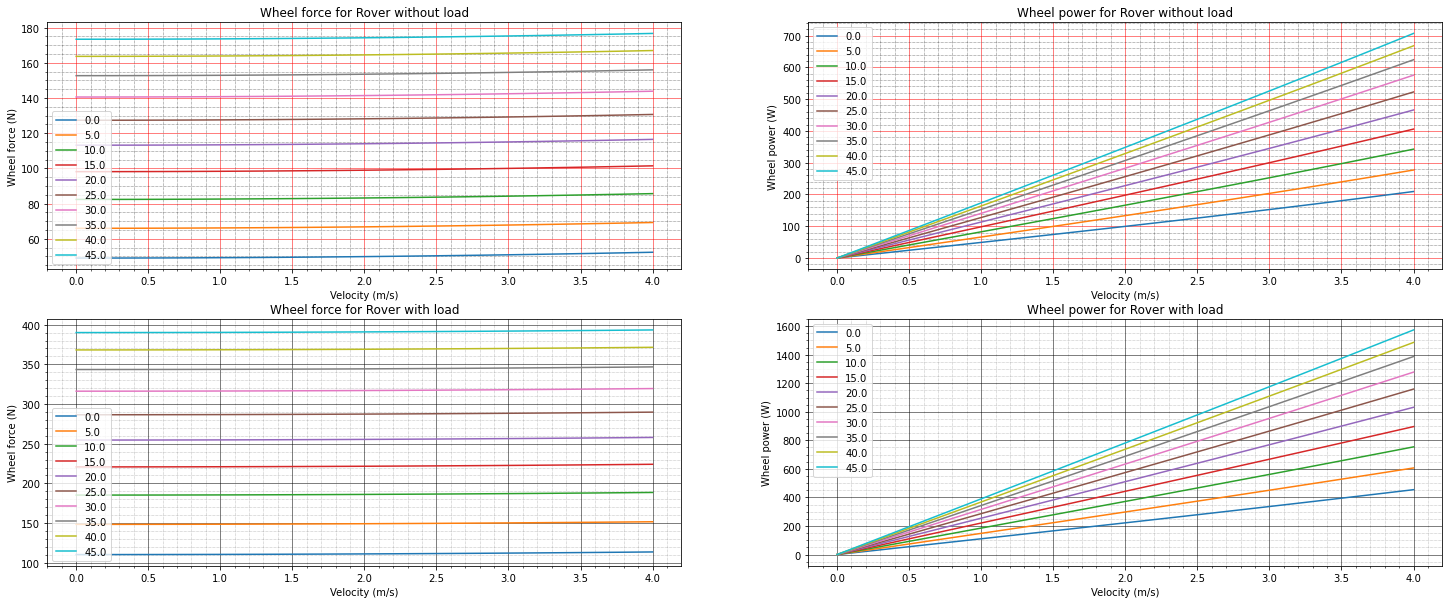

In [4]:
wheel_forces_without_load = []
wheel_power_without_load = []

wheel_forces_with_load = []
wheel_power_with_load = []
columns = ['velocity']

velocity_step = 0.1
for velocity in np.arange(0.0, max_velocity_flat + velocity_step,
                          velocity_step):
    
    forces_without_load = [ velocity ]
    powers_without_load = [ velocity ]

    forces_with_load = [ velocity ]
    powers_with_load = [ velocity ]

    slope_step = 5.0
    for slope in np.arange(0.0, max_hill_angle_empty + slope_step,
                           slope_step):

        slope_as_text = str(slope)
        if slope_as_text not in columns:
            columns.append(slope_as_text)

        wheel_force_without_load, power_without_load = wheel_load(
            rover_width * rover_height,
            coefficient_of_aerodynamic_drag,
            velocity,
            rover_mass_in_kg,
            coefficient_of_friction,
            slope)

        forces_without_load.append(wheel_force_without_load)
        powers_without_load.append(power_without_load)

        wheel_force_with_load, power_with_load = wheel_load(
            rover_width * rover_height,
            coefficient_of_aerodynamic_drag,
            velocity,
            rover_mass_in_kg + crate_mass_in_kg,
            coefficient_of_friction,
            slope)

        forces_with_load.append(wheel_force_with_load)
        powers_with_load.append(power_with_load)

    wheel_forces_without_load.append(forces_without_load)
    wheel_power_without_load.append(powers_without_load)

    wheel_forces_with_load.append(forces_with_load)
    wheel_power_with_load.append(powers_with_load)

force_without_load_df = pd.DataFrame(wheel_forces_without_load, columns=columns)
power_without_load_df = pd.DataFrame(wheel_power_without_load, columns=columns)

force_with_load_df = pd.DataFrame(wheel_forces_with_load, columns=columns)
power_with_load_df = pd.DataFrame(wheel_power_with_load, columns=columns)

fig, ax_group = plt.subplots(2, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

force_without_load_df.plot(x='velocity', ax=axs[0])
axs[0].set_title('Wheel force for Rover without load')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Wheel force (N)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

power_without_load_df.plot(x='velocity', ax=axs[1])
axs[1].set_title('Wheel power for Rover without load')
axs[1].set_xlabel('Velocity (m/s)')
axs[1].set_ylabel('Wheel power (W)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')


force_with_load_df.plot(x='velocity', ax=axs[2])
axs[2].set_title('Wheel force for Rover with load')
axs[2].set_xlabel('Velocity (m/s)')
axs[2].set_ylabel('Wheel force (N)')
axs[2].set_axisbelow(True)
axs[2].minorticks_on()
axs[2].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[2].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

power_with_load_df.plot(x='velocity', ax=axs[3])
axs[3].set_title('Wheel power for Rover with load')
axs[3].set_xlabel('Velocity (m/s)')
axs[3].set_ylabel('Wheel power (W)')
axs[3].set_axisbelow(True)
axs[3].minorticks_on()
axs[3].grid(which='major', linestyle='-', linewidth='0.5', color='black')
axs[3].grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)

plt.show()

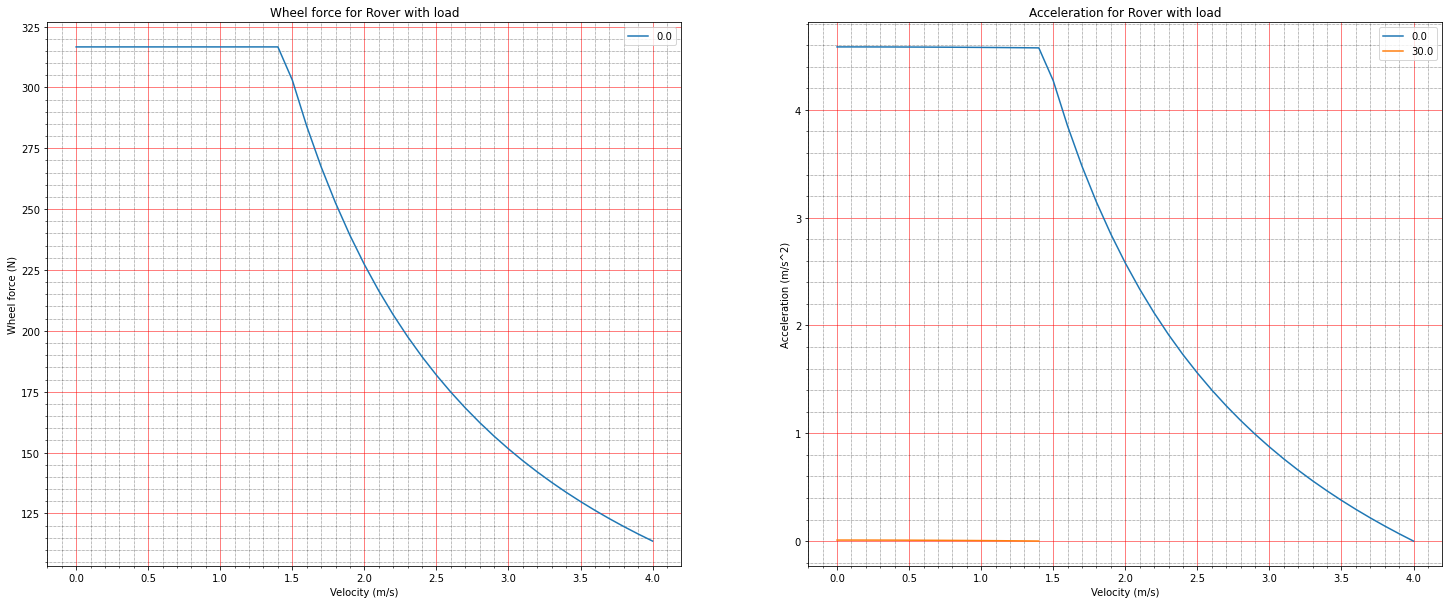

In [18]:
# Determine minimum power and force requirements
#minium_required_power = 

minimum_power_required = power_with_load_df['0.0'][max_velocity_flat * 10]

velocity_max_at_max_slope = velocity_for_slope_and_power(
    minimum_power_required, 
    rover_width * rover_height,
    coefficient_of_aerodynamic_drag,
    rover_mass_in_kg + crate_mass_in_kg,
    coefficient_of_friction,
    max_hill_angle_max_load)

force_at_max_slope = minimum_power_required / velocity_max_at_max_slope

wheel_forces_for_power_curve = []
rover_acceleration_for_power_curve = []

velocity_step = 0.1
for velocity in np.arange(0.0, max_velocity_flat + velocity_step,
                          velocity_step):
    forces_for_power_curve = [ velocity ]
    acceleration_for_power_curve = [ velocity ]
    
    if velocity < velocity_max_at_max_slope:
        force = force_at_max_slope
    else:
        power = minimum_power_required
        force = power / velocity

    forces_for_power_curve.append(force)

    minimum_force_flat, _ = wheel_load(
            rover_width * rover_height,
            coefficient_of_aerodynamic_drag,
            velocity,
            rover_mass_in_kg + crate_mass_in_kg,
            coefficient_of_friction,
            0)

    minimum_force_slope, _ = wheel_load(
            rover_width * rover_height,
            coefficient_of_aerodynamic_drag,
            velocity,
            rover_mass_in_kg + crate_mass_in_kg,
            coefficient_of_friction,
            max_hill_angle_max_load)

    acceleration_flat = (force - minimum_force_flat) / (rover_mass_in_kg + crate_mass_in_kg)
    acceleration_for_power_curve.append(acceleration_flat)

    if velocity < velocity_max_at_max_slope:
        acceleration_for_power_curve.append((force - minimum_force_slope) / (rover_mass_in_kg + crate_mass_in_kg))

    wheel_forces_for_power_curve.append(forces_for_power_curve)
    rover_acceleration_for_power_curve.append(acceleration_for_power_curve)

force_for_power_curve_df = pd.DataFrame(wheel_forces_for_power_curve, columns=['velocity', '0.0'])
acceleration_for_power_curve_df = pd.DataFrame(rover_acceleration_for_power_curve, columns=['velocity', '0.0', '30.0'])

fig, ax_group = plt.subplots(1, 2, figsize=(25, 10), sharex=False)

# unpack all the axes subplots
axs = ax_group.ravel()

force_for_power_curve_df.plot(x='velocity', ax=axs[0])
axs[0].set_title('Wheel force for Rover with load')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Wheel force (N)')
axs[0].set_axisbelow(True)
axs[0].minorticks_on()
axs[0].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[0].grid(which='minor', linestyle=':', linewidth='0.5', color='black')

acceleration_for_power_curve_df.plot(x='velocity', ax=axs[1])
axs[1].set_title('Acceleration for Rover with load')
axs[1].set_xlabel('Velocity (m/s)')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].set_axisbelow(True)
axs[1].minorticks_on()
axs[1].grid(which='major', linestyle='-', linewidth='0.5', color='red')
axs[1].grid(which='minor', linestyle=':', linewidth='0.5', color='black')


Notes:

* We need to be able to accelerate when going up the hill otherwise we can't get going
* Need to figure out what our maximum force can be on the ground before we slip (can we even go up the hill?)
* Work out the torgue levels for the motors for each wheel
* Work out the power levels for the motors for each wheel


Further

* Rover inertia?
* Wheel inertia
* Steering power
* Braking power
* Battery size
* Motor selection


Design

* Brakes + hold power for on the hill / when loading
* Suspension for individual wheels. At 4.0 m/s hitting anything will be nasty because the swing arms are large with heavy weights at the end (the wheels + motors)
* stability
  * Center of gravity
  * Front to back slope
  * Side slope


## Rover arm sizing